In this notebook, we will construct some general bigram transition matrices.

In [1]:
# General Code for Loading Gutenburg Text
# Load list of fiction
import pickle, gzip
import zipfile

# Get a list of fiction
fiction_dict = pickle.load(gzip.open("fiction_list.gz", 'rb'))
ids = list(fiction_dict.keys())
test_book = fiction_dict[ids[0]]

with zipfile.ZipFile(test_book['path'], 'r') as book_zip:
    # We might want to change this to open the one txt file in the zip
    with book_zip.open('{0}.txt'.format(test_book['id'])) as txtfile:
        text = txtfile.read().decode()
        
print("The book is {0} text characters long".format(len(text)))

The book is 306904 text characters long


In [2]:
test_book['path']

'./1/0/0/0/10002/10002.zip'

*** NOTE: not absolute path so need to run in this folder. ***

In [3]:
text[0:20]

"Project Gutenberg's "

In [4]:
type(text)

str

In [5]:
lowercase = text.lower(); lowercase[0:50]

"project gutenberg's the house on the borderland, b"

Importing the character dictionary we built here - https://github.com/benhoyle/patentdata/blob/spacy/patentdata/models/chardict.py.

Amending the character set to have a reduced number.

In [6]:
from chardict import CharDict

In [12]:
# Turn off OOD and CAPITAL tokens to get to a power of 2
chardict = CharDict(special=False)

In [13]:
chardict.text2int(lowercase[0:20])

[15, 17, 14, 9, 4, 2, 19, 27, 6, 20, 19, 4, 13, 1, 4, 17, 6, 31, 18, 27]

In [14]:
chardict.reverse_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [15]:
integers = chardict.text2int(lowercase)

In [16]:
len(integers)

292945

To determine a bigram transition matrix, we convert each integer into a one-hot representation. Then we create a transition matrix the same length as the keys. Then we simply increment mat[i, j] with i and j as the two consecutive characters.

In [17]:
chardict.vocabulary_size

32

In [18]:
type(integers[9])

int

In [19]:
import numpy as np

Now we are going to experiment with using the Hadamard matrix as a pre-processing transformation.

The process flow is:
* Prepare Hadamard matrix with n by n size equal to the number of characters - H.
* Obtain current character as one-hot vector - C_i_onehot.
* Get the dot product of H.C_i_onehot to get another vector of the decompostion C_i_decom.
* Repeat above two steps for next character to get C_i_plus_1_decom.
* Build correlation matrix for the two vectors (as per variance processor code) - we'd need to remove the mean (but the mean of the non-A rows are 0?)

How would you prepare the data if computing the covariance offline? Concatenate and take the sub-matrix? C_i || C_i_plus_1. We can use this - https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EmpiricalCovariance.html. Where X = the concatenation. As a bonus of this we also get the backwards temporal correlation and the self-correlation.

So our chardict is passed the lowercase text and returns a list of integers. We could have a text to one hot method (but this might create a very large matrix). Best to convert late.

One issues: Hadamard matrix needs to be a power of 2!

We can limit to 64, which means we need to limit the characters to 32...

In [20]:
import string
character_set = (
                string.ascii_lowercase +
                "! ,.?'"
)
len(character_set)

32

In [21]:
# We need to add a method that returns a one-hot encoding
def one_hot(integer, size):
    """Convert an integer to a one hot vector of max length size."""
    one_hot = np.zeros(shape=(size, 1), dtype=np.uint8)
    one_hot[integer] = 1
    return one_hot

In [22]:
one_hot(12, chardict.vocabulary_size).T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [23]:
joined = np.concatenate(
    [one_hot(12, chardict.vocabulary_size), 
    one_hot(26, chardict.vocabulary_size)]
)
print(joined.T, joined.shape)

[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]] (64, 1)


In [24]:
from scipy.linalg import hadamard

In [25]:
H = hadamard(chardict.vocabulary_size*2)
transformed = np.dot(H, joined)

In [26]:
transformed.shape

(64, 1)

In [27]:
transformed.T

array([[ 2,  2,  0,  0,  0,  0, -2, -2, -2, -2,  0,  0,  0,  0,  2,  2,
         0,  0,  2,  2, -2, -2,  0,  0,  0,  0, -2, -2,  2,  2,  0,  0,
         0,  0,  2,  2, -2, -2,  0,  0,  0,  0, -2, -2,  2,  2,  0,  0,
         2,  2,  0,  0,  0,  0, -2, -2, -2, -2,  0,  0,  0,  0,  2,  2]])

Ah so we will need to divide by the average (2) to get a binary array.

In [31]:
transformed[0, 0]

2

In [28]:
transformed.T//2

array([[ 1,  1,  0,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0,  1,  1,
         0,  0,  1,  1, -1, -1,  0,  0,  0,  0, -1, -1,  1,  1,  0,  0,
         0,  0,  1,  1, -1, -1,  0,  0,  0,  0, -1, -1,  1,  1,  0,  0,
         1,  1,  0,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0,  1,  1]])

In [38]:
transformed[:, 0].shape

(64,)

In [43]:
# Define transition matrix
num_ints = chardict.vocabulary_size
# Get size of data matrix - samples, features
concate_length = num_ints*2
shape = (len(integers), concate_length)
# We need signed integers as we have negative values
data_matrix = np.zeros(shape=shape, dtype=np.int8)
# Get Hadamard matrix
H = hadamard(concate_length)
# For each pair of characters
sample_index = 0
for char_1, char_2 in zip(integers[0:-1], integers[1:]):
    C_1_onehot = one_hot(char_1, num_ints)
    C_2_onehot = one_hot(char_2, num_ints)
    joined = np.concatenate([C_1_onehot, C_2_onehot])
    # Transform using Hadamard and normalise with average
    transformed = np.dot(H, joined)//2
    data_matrix[sample_index, :] = transformed[:, 0]
    sample_index += 1

In [44]:
data_matrix[0:5, :]

array([[ 1, -1,  0,  0,  0,  0,  1, -1,  0,  0,  1, -1,  1, -1,  0,  0,
         0,  0, -1,  1, -1,  1,  0,  0, -1,  1,  0,  0,  0,  0, -1,  1,
         0,  0, -1,  1, -1,  1,  0,  0, -1,  1,  0,  0,  0,  0, -1,  1,
         1, -1,  0,  0,  0,  0,  1, -1,  0,  0,  1, -1,  1, -1,  0,  0],
       [ 1,  0,  0, -1,  0, -1,  1,  0,  0, -1,  1,  0,  1,  0,  0, -1,
         0,  1, -1,  0, -1,  0,  0,  1, -1,  0,  0,  1,  0,  1, -1,  0,
         0, -1,  1,  0,  1,  0,  0, -1,  1,  0,  0, -1,  0, -1,  1,  0,
        -1,  0,  0,  1,  0,  1, -1,  0,  0,  1, -1,  0, -1,  0,  0,  1],
       [ 1,  0,  0, -1,  0, -1,  1,  0, -1,  0,  0,  1,  0,  1, -1,  0,
         1,  0,  0, -1,  0, -1,  1,  0, -1,  0,  0,  1,  0,  1, -1,  0,
         0,  1, -1,  0, -1,  0,  0,  1,  0, -1,  1,  0,  1,  0,  0, -1,
         0,  1, -1,  0, -1,  0,  0,  1,  0, -1,  1,  0,  1,  0,  0, -1],
       [ 1,  0,  1,  0,  0, -1,  0, -1,  0,  1,  0,  1, -1,  0, -1,  0,
         1,  0,  1,  0,  0, -1,  0, -1,  0,  1,  0,  1, -1,  

In [46]:
np.set_printoptions(suppress=True)

In [47]:
# Fit covariance
from sklearn.covariance import EmpiricalCovariance
cov = EmpiricalCovariance().fit(data_matrix)
print(cov.covariance_)
# Below is the mean estimate
print(cov.location_)

[[ 0.00000341 -0.0000002  -0.00000036 ... -0.         -0.
   0.        ]
 [-0.0000002   0.40563831  0.14709757 ...  0.03479131  0.00425998
  -0.0157775 ]
 [-0.00000036  0.14709757  0.47014656 ...  0.07332057  0.00987522
  -0.03476726]
 ...
 [-0.          0.03479131  0.07332057 ...  0.47062418  0.18660841
  -0.04549318]
 [-0.          0.00425998  0.00987522 ...  0.18660841  0.49801499
  -0.01792828]
 [ 0.         -0.0157775  -0.03476726 ... -0.04549318 -0.01792828
   0.51616174]]
[ 0.99999659 -0.05924662 -0.10466128  0.36599362  0.16520166 -0.27376811
 -0.2938538   0.28332622  0.07580945  0.15585178  0.09709672 -0.02816911
 -0.02914882  0.01827988  0.04922084 -0.37900288  0.1168547   0.3101333
  0.28810869  0.00334534 -0.3828193   0.27731144  0.26529553 -0.03998361
  0.07232757 -0.05509567 -0.00178873  0.3903941   0.02904641 -0.09827442
 -0.14078069 -0.01594497  0.          0.          0.          0.
 -0.00000341  0.00000341  0.00000341 -0.00000341  0.          0.
  0.          0.      

Interesting so the mean is not zero - some characters occur more often.

In [48]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


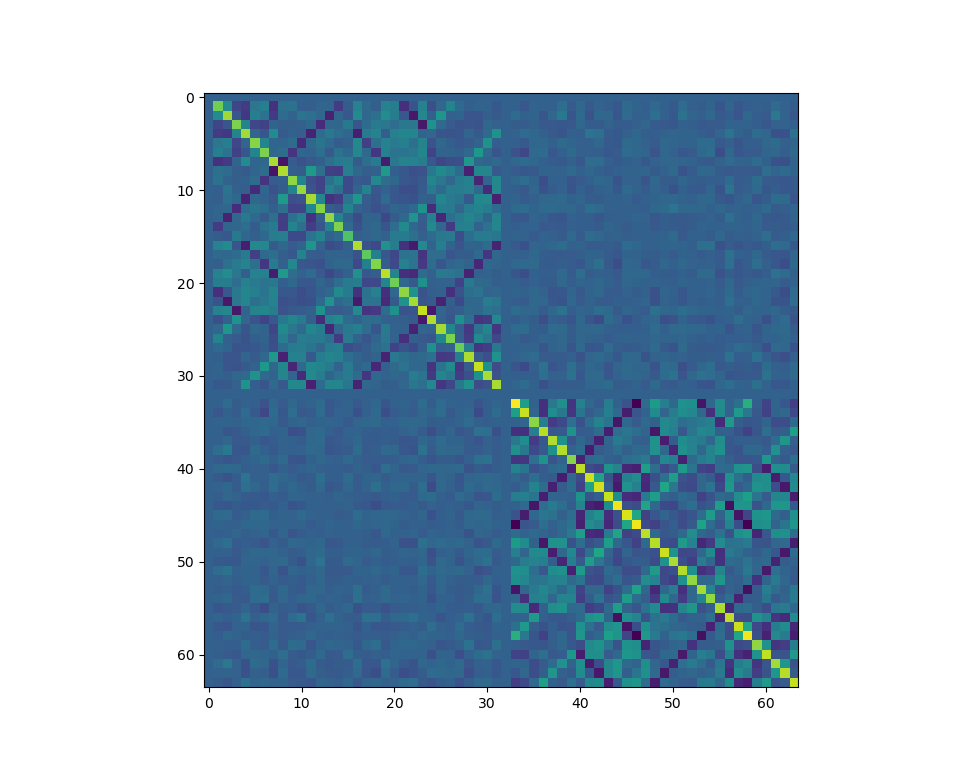

In [142]:
%matplotlib notebook
plt.imshow(cov.covariance_)

The top left and bottom right patterns should be the same - which is true - this is the C_i self-covariance and the C_i_plus_1 self-covariance.

Top right is the covariance between the next character and the current character. Bottom left is the reverse covariance, i.e. from i_plus_1 to i.

Matrix is symmetric.

Everything is normalised.

0 and 32 seem blank - is this right? Yes as the first value will always be 1. Likewise the 32nd value will always be 1. This is because these are the two average terms.

So we can actually ignore the average...as this is always 1?

Or see it as a probability of output / no-output?

In [ ]:
np.array_equal(cov.covariance_[:32])

In [51]:
cov.covariance_.max()

0.5908481114202325

In [52]:
cov.covariance_.min()

-0.2643636177439451

Can we use the covariance matrix as a transition matrix?

We'd need to create a one hot encoding of the current character, transform, then multiply by the covariance matrix?

In [56]:
char_a = chardict.text2int("a")

In [116]:
# Get the one hot encoding for a
char = one_hot(char_a, chardict.vocabulary_size)
print(char.T, char.shape)
# Add on a blank vector for the next character
padded = np.pad(char, ((0, num_ints), (0,0)))
print(padded.shape, padded.T)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]] (32, 1)
(64, 1) [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [117]:
transformed = np.dot(H, padded); print(transformed.T)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [118]:
np.array_equal(H.T, H)

True

In [119]:
output = np.dot(cov.covariance_, transformed)

In [120]:
output.shape

(64, 1)

In [121]:
output.T

array([[0.00000704, 0.74551771, 1.11930899, 0.17995814, 1.07673182,
        1.51689435, 1.12102227, 0.74468049, 1.00186749, 0.77823631,
        0.48194483, 0.89797004, 1.53519383, 0.69802538, 0.96359943,
        1.48232892, 0.77275235, 0.36183227, 0.67671026, 0.96420886,
        1.36282615, 0.74997698, 0.39493053, 1.30497242, 0.38541825,
        1.38309048, 0.87658773, 0.46272649, 0.98387914, 1.09915423,
        1.59541212, 1.01816789, 0.        , 1.43764871, 1.15745959,
        1.12676441, 0.6438412 , 1.10840581, 1.5456756 , 0.73243121,
        0.90294083, 0.9616003 , 1.37898923, 1.2211439 , 0.5859323 ,
        1.32536162, 0.99601653, 1.35986598, 1.04745942, 1.06002151,
        0.79053747, 1.08995204, 1.48724867, 0.73951745, 1.11932936,
        0.8384989 , 1.52656642, 0.79152059, 1.18815477, 0.7937053 ,
        1.01730338, 1.1644577 , 0.75580761, 1.07574439]])

In [122]:
np.dot(H, output).T

array([[ 61.70583541,  -0.72292618,  -1.20337602,  -2.45966007,
         -6.58063195,  -1.1754586 ,  -1.29590877,  -3.1717795 ,
         -3.67159143,  -0.04795493,  -0.38814224,  -2.0852514 ,
         -1.33305696,  -3.6603344 ,  -3.83121605,  -0.95504604,
         -0.0511069 ,  -2.88967844,  -3.17853371,  -5.22843805,
         -1.50866655,  -0.43722287,  -1.26506452,  -0.06033766,
         -0.95774773,  -0.05245774,  -0.02296433, -11.21672532,
         -1.46971725,  -0.71887365,  -0.01733582,  -0.04840521,
         -4.23396899,   0.64382868,   1.53712475,   1.68255093,
         -6.53868551,  -0.58121736,   0.03938625,  -3.08439108,
         -1.4309524 ,  -0.04795493,   0.3773803 ,   1.74213615,
          0.64541682,   8.1301109 ,  -3.71586334,   0.43989824,
         -0.04761136,   3.99303333,   4.29142823,   3.98230117,
         -1.10667983,   1.18121062,  -0.15348385,  -0.02188675,
          0.72010989,   0.16426554,  -0.0194688 ,  -6.42784004,
         -1.42427527,  -0.67692721,  -0.

Covariance matrix is orthogonal - the transverse is the same as the original matrix. So it doesn't matter if we do cov or cov.T. This then allows generative models - we can reverse.

We only want the last 32.

In [123]:
transformed_output = np.dot(H, output)
transformed_output[32:, :].T

array([[-4.23396899,  0.64382868,  1.53712475,  1.68255093, -6.53868551,
        -0.58121736,  0.03938625, -3.08439108, -1.4309524 , -0.04795493,
         0.3773803 ,  1.74213615,  0.64541682,  8.1301109 , -3.71586334,
         0.43989824, -0.04761136,  3.99303333,  4.29142823,  3.98230117,
        -1.10667983,  1.18121062, -0.15348385, -0.02188675,  0.72010989,
         0.16426554, -0.0194688 , -6.42784004, -1.42427527, -0.67692721,
        -0.01384028, -0.04490967]])

How do we turn this into a probability vector?

We have both +ve and -ve values. We can normalise by softmax? Basically compute np.exp(transformed_output) / np.exp(transformed_output).sum().

In [144]:
to_the_e = np.exp(transformed_output[32:, :])
print(to_the_e/to_the_e.sum())

[[0.00000401]
 [0.00052665]
 [0.0012867 ]
 [0.00148811]
 [0.0000004 ]
 [0.0001547 ]
 [0.00028775]
 [0.00001266]
 [0.00006614]
 [0.00026369]
 [0.00040347]
 [0.00157947]
 [0.00052749]
 [0.93923515]
 [0.00000673]
 [0.00042949]
 [0.00026378]
 [0.01499907]
 [0.02021416]
 [0.01483896]
 [0.00009147]
 [0.00090137]
 [0.00023728]
 [0.00027065]
 [0.0005684 ]
 [0.00032603]
 [0.0002713 ]
 [0.00000045]
 [0.00006658]
 [0.00014058]
 [0.00027284]
 [0.00026449]]


In [124]:
transformed_output[32:, :].shape

(32, 1)

So a is actually not likely.

In [125]:
np.argmax(transformed_output[32:, :])

13

In [126]:
chardict.int2char(np.argmax(transformed_output[32:, :]))

'n'

In [127]:
np.argsort(transformed_output[32:, :], axis=0).T

array([[ 4, 27,  0, 14,  7,  8, 28, 20, 29,  5, 22,  9, 16, 31, 23, 26,
        30,  6, 25, 10, 15,  1, 12, 24, 21,  2,  3, 11, 19, 17, 18, 13]])

In [128]:
np.argsort(transformed_output[32:, :], axis=0).shape

(32, 1)

In [129]:
np.argsort(transformed_output[32:, :], axis=0)[0].item()

4

In [130]:
# argsort returns list in reverse order
ordered_indices = np.argsort(transformed_output[32:, :], axis=0)
for index in np.flip(ordered_indices, axis=0):
    print(chardict.int2char(index.item()), end=",")

n,s,r,t,l,d,c,v,y,m,b,p,k,z,g,?,!,x,',q,j,w,f,.,u,,,i,h,o,a, ,e,

This looks right - ae is extremely uncommon. "an" is common as it is in "and"

In [158]:
def predict_next(char, cov, chardict, H):
    """Predict next character using covariance matrix."""
    char_num = chardict.text2int(char)
    char = one_hot(char_num, chardict.vocabulary_size)
    # Add on a blank vector for the next character
    padded = np.pad(char, ((0, chardict.vocabulary_size), (0,0)))
    transformed = np.dot(H, padded)
    output = np.dot(cov.covariance_, transformed)
    transformed_output = np.dot(H, output)
    # Perform softmax
    to_the_e = np.exp(transformed_output[32:, :])
    probabilities = to_the_e/to_the_e.sum()
    ordered_indices = np.argsort(transformed_output[32:, :], axis=0)
    for index in np.flip(ordered_indices, axis=0):
        # Print character and weight
        print(
            f"Char: {chardict.int2char(index.item())}; probability:{probabilities[index].item():.5f}"
        )

In [159]:
predict_next("e", cov, chardict, H)

Char:  ; probability:0.96061
Char: r; probability:0.02316
Char: d; probability:0.01499
Char: n; probability:0.00079
Char: ,; probability:0.00009
Char: .; probability:0.00004
Char: s; probability:0.00004
Char: v; probability:0.00003
Char: x; probability:0.00003
Char: c; probability:0.00002
Char: a; probability:0.00002
Char: m; probability:0.00002
Char: p; probability:0.00002
Char: ?; probability:0.00002
Char: !; probability:0.00002
Char: q; probability:0.00002
Char: '; probability:0.00002
Char: z; probability:0.00001
Char: j; probability:0.00001
Char: l; probability:0.00001
Char: k; probability:0.00001
Char: y; probability:0.00001
Char: f; probability:0.00001
Char: b; probability:0.00001
Char: w; probability:0.00001
Char: g; probability:0.00000
Char: u; probability:0.00000
Char: h; probability:0.00000
Char: i; probability:0.00000
Char: t; probability:0.00000
Char: o; probability:0.00000
Char: e; probability:0.00000


----

In [160]:
def to_one_hot(char):
    char_num = chardict.text2int(char)
    char = one_hot(char_num, chardict.vocabulary_size)
    return char

In [161]:
t = to_one_hot("t")
h = to_one_hot("h")
e = to_one_hot("e")

In [162]:
the = np.concatenate([t, h, e], axis=1); the.shape

(32, 3)

In [163]:
the.T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [165]:
padded = np.pad(the, ((0, 32),(0, 0))); padded.shape; padded.T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=uint8)

In [167]:
transformed = np.dot(H, padded)
transformed.T

array([[ 1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,
        -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1,
         1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,
        -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1],
       [ 1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1,
         1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1,
         1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1,
         1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1],
       [ 1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,
         1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,
         1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,
         1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1]])

<IPython.core.display.Javascript object>


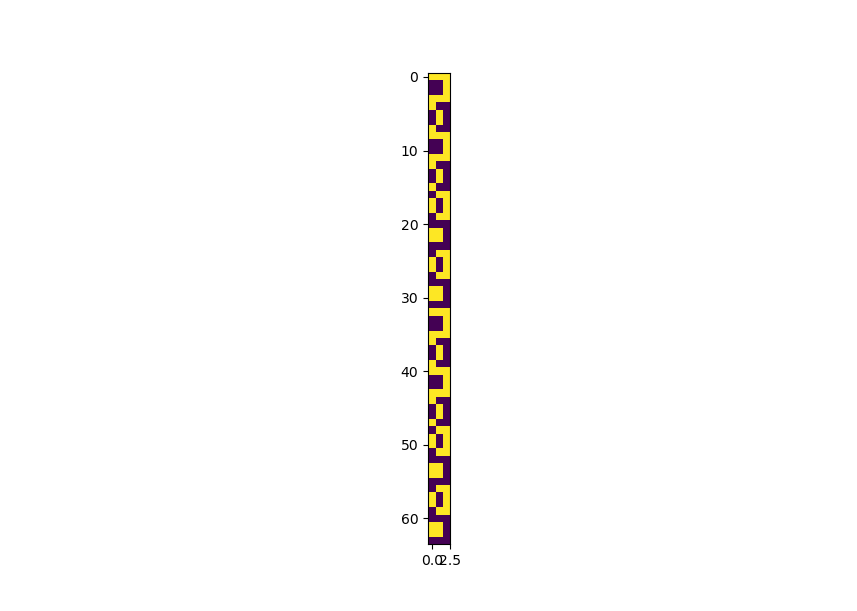

In [168]:
plt.imshow(transformed)

In [169]:
transformed.mean(axis=1)

array([ 1.        , -0.33333333, -0.33333333,  1.        , -0.33333333,
       -0.33333333, -0.33333333, -0.33333333,  1.        , -0.33333333,
       -0.33333333,  1.        , -0.33333333, -0.33333333, -0.33333333,
       -0.33333333,  0.33333333,  0.33333333,  0.33333333,  0.33333333,
       -1.        ,  0.33333333,  0.33333333, -1.        ,  0.33333333,
        0.33333333,  0.33333333,  0.33333333, -1.        ,  0.33333333,
        0.33333333, -1.        ,  1.        , -0.33333333, -0.33333333,
        1.        , -0.33333333, -0.33333333, -0.33333333, -0.33333333,
        1.        , -0.33333333, -0.33333333,  1.        , -0.33333333,
       -0.33333333, -0.33333333, -0.33333333,  0.33333333,  0.33333333,
        0.33333333,  0.33333333, -1.        ,  0.33333333,  0.33333333,
       -1.        ,  0.33333333,  0.33333333,  0.33333333,  0.33333333,
       -1.        ,  0.33333333,  0.33333333, -1.        ])

In [170]:
np.around(transformed.mean(axis=1))

array([ 1., -0., -0.,  1., -0., -0., -0., -0.,  1., -0., -0.,  1., -0.,
       -0., -0., -0.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,
        0.,  0., -1.,  0.,  0., -1.,  1., -0., -0.,  1., -0., -0., -0.,
       -0.,  1., -0., -0.,  1., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.])

In [180]:
the_mean = np.around(transformed.mean(axis=1))
t_diff = padded[:, 0] - the_mean
h_diff = padded[:, 1] - the_mean
e_diff = padded[:, 2] - the_mean
print(t_diff.T, h_diff.T, e_diff.T)

[-1.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1. -1.  0.  0. -1.
  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.] [-1.  0.  0. -1.  0.  0.  0.  1. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1. -1.  0.  0. -1.
  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.] [-1.  0.  0. -1.  1.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1. -1.  0.  0. -1.
  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.]


In [179]:
the_mean.shape, padded[:, 0].shape, t_diff.shape

((64, 1), (64,), (64, 64))

<IPython.core.display.Javascript object>


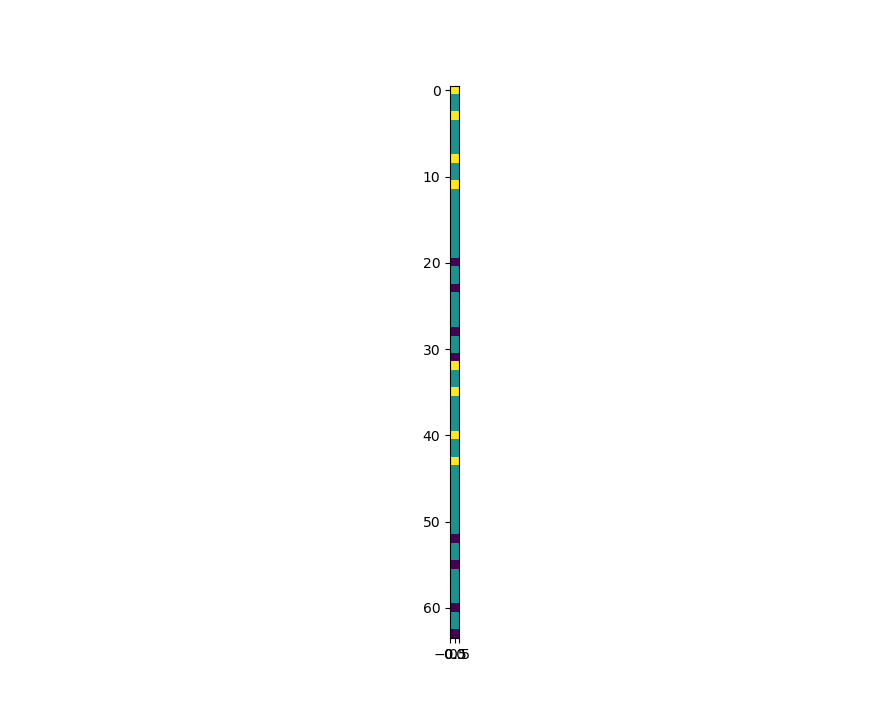

In [187]:
plt.imshow(the_mean.reshape(-1, 1))

<IPython.core.display.Javascript object>


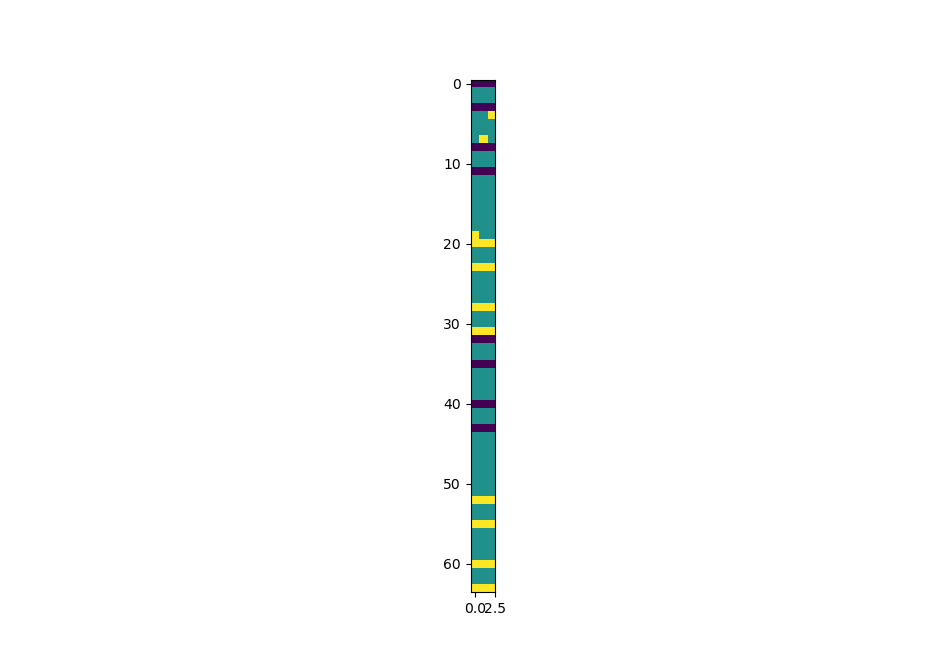

In [185]:
diff_array = np.stack([t_diff, h_diff, e_diff])
plt.imshow(diff_array.T)

So there's only one change in the activation per letter.

Also should we also be looking at \<START>, \<STOP> e.g. as represented by - space -.

## Different COV combinations

We can first determine COV of C_i_trans > C_i_trans (covariance(X)).

We can then use this to compute C_i_trans_dash = COV.C_i_trans. We can then compute diff = C_i_plus_1_trans - C_i_trans_dash and compute either COV(C_i_trans, diff) or COV(C_i_trans_dash, diff). Let's try both below.

If we don't have the COV(C_i_trans) we can use identity matrix (which is C_i_trans).

In [188]:
# Define transition matrix
num_ints = chardict.vocabulary_size
# Get size of data matrix - samples, features
shape = (len(integers), num_ints)
# We need signed integers as we have negative values
data_matrix_1 = np.zeros(shape=shape, dtype=np.int8)
data_matrix_2 = np.zeros(shape=shape, dtype=np.int8)
# Get Hadamard matrix
H = hadamard(num_ints)
# For each pair of characters
sample_index = 0
for char_1, char_2 in zip(integers[0:-1], integers[1:]):
    C_1_onehot = one_hot(char_1, num_ints)
    C_2_onehot = one_hot(char_2, num_ints)
    # Transform using Hadamard and normalise with average
    C_1_trans = np.dot(H, C_1_onehot)
    C_2_trans = np.dot(H, C_2_onehot)
    data_matrix_1[sample_index, :] = C_1_trans[:, 0]
    data_matrix_2[sample_index, :] = C_2_trans[:, 0] - C_1_trans[:, 0]
    sample_index += 1
    
# Fit covariance
cov_1 = EmpiricalCovariance().fit(data_matrix_1)
cov_2 = EmpiricalCovariance().fit(data_matrix_2)

<IPython.core.display.Javascript object>


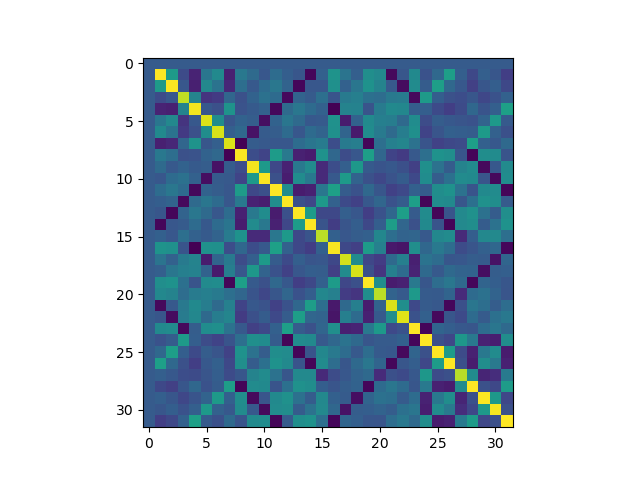

In [192]:
plt.imshow(cov_1.covariance_)

This is what we had before - good.

<IPython.core.display.Javascript object>


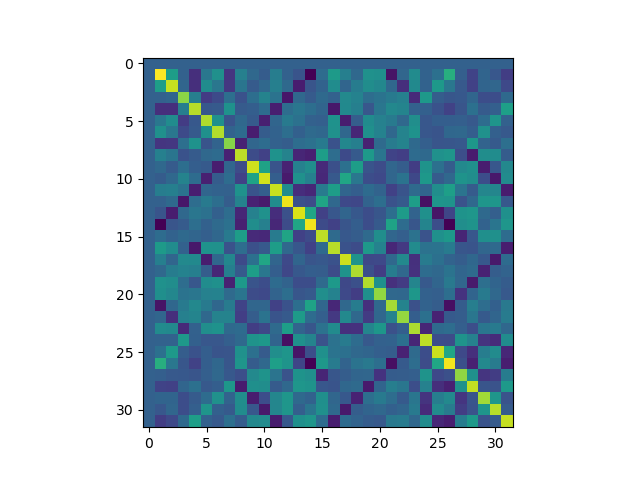

In [193]:
plt.imshow(cov_2.covariance_)

Same pattern but different values...is this right?

In [194]:
C_2_trans[:, 0] - C_1_trans[:, 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [195]:
# Look at means
print(cov_1.location_, cov_2.location_)

[ 0.99999659 -0.05924662 -0.10466128  0.36599362  0.16519825 -0.2737647
 -0.29385038  0.28332281  0.07580945  0.15585178  0.09709672 -0.02816911
 -0.0291454   0.01827647  0.04921743 -0.37899947  0.1168547   0.3101333
  0.28810869  0.00334534 -0.38282271  0.27731485  0.26529895 -0.03998703
  0.07232757 -0.05509567 -0.00178873  0.3903941   0.02904982 -0.09827783
 -0.14078411 -0.01594156] [ 0.          0.          0.          0.          0.00000683 -0.00000683
 -0.00000683  0.00000683  0.          0.          0.          0.
 -0.00000683  0.00000683  0.00000683 -0.00000683  0.          0.
  0.          0.          0.00000683 -0.00000683 -0.00000683  0.00000683
  0.          0.          0.          0.         -0.00000683  0.00000683
  0.00000683 -0.00000683]


Zero mean for the second case...

In [197]:
print(cov_1.covariance_[0:5], cov_2.covariance_[0:5], end="\n\n")

[[ 0.00000341 -0.0000002  -0.00000036  0.00000125  0.00000056 -0.00000093
  -0.000001    0.00000097  0.00000026  0.00000053  0.00000033 -0.0000001
  -0.0000001   0.00000006  0.00000017 -0.00000129  0.0000004   0.00000106
   0.00000098  0.00000001 -0.00000131  0.00000095  0.00000091 -0.00000014
   0.00000025 -0.00000019 -0.00000001  0.00000133  0.0000001  -0.00000034
  -0.00000048 -0.00000005]
 [-0.0000002   0.99648642  0.35979279 -0.0829774  -0.26397726  0.14897861
   0.26591317 -0.27706446  0.16034323  0.08504314 -0.02241646  0.0954278
   0.0165497  -0.02806258 -0.3760835   0.02676299  0.31705655  0.13522905
   0.0204148   0.28830689  0.2546339  -0.36639275 -0.02426896  0.26292985
  -0.0508105   0.06906334  0.39028812  0.0213408  -0.09655673  0.02322719
  -0.02428254 -0.14172859]
 [-0.00000036  0.35979279  0.9890426  -0.02094125 -0.27656052  0.25467024
   0.13444349 -0.24411177  0.10503104 -0.01185746  0.08597172  0.15290357
   0.04616703 -0.37708663 -0.02399424 -0.0213901   0.3003388

They are similar but have different values...

<IPython.core.display.Javascript object>


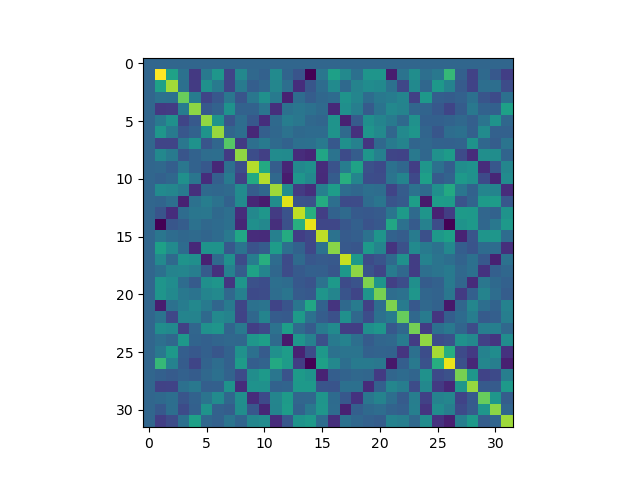

In [198]:
plt.imshow(cov_2.covariance_ - cov_1.covariance_)

Let's check the data matrices...

In [199]:
data_matrix_1[0:5]

array([[ 1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1,
         1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1],
       [ 1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1],
       [ 1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1,
         1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1],
       [ 1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,
         1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1],
       [ 1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,
         1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1]],
      dtype=int8)

In [201]:
data_matrix_2[0:20]

array([[ 0,  0,  2, -2,  2, -2,  0,  0,  2, -2,  0,  0,  0,  0,  2, -2,
        -2,  2,  0,  0,  0,  0, -2,  2,  0,  0, -2,  2, -2,  2,  0,  0],
       [ 0,  2, -2,  0, -2,  0,  0,  2, -2,  0,  0,  2,  0,  2, -2,  0,
         2,  0,  0, -2,  0, -2,  2,  0,  0, -2,  2,  0,  2,  0,  0, -2],
       [ 0, -2,  2,  0,  2,  0,  0, -2,  0,  2, -2,  0, -2,  0,  0,  2,
         0, -2,  2,  0,  2,  0,  0, -2,  0,  2, -2,  0, -2,  0,  0,  2],
       [ 0,  2,  0,  2, -2,  0, -2,  0,  2,  0,  2,  0,  0, -2,  0, -2,
         0,  2,  0,  2, -2,  0, -2,  0,  2,  0,  2,  0,  0, -2,  0, -2],
       [ 0,  0, -2, -2,  2,  2,  0,  0,  0,  0, -2, -2,  2,  2,  0,  0,
         0,  0, -2, -2,  2,  2,  0,  0,  0,  0, -2, -2,  2,  2,  0,  0],
       [ 0, -2,  0,  2,  0, -2,  0,  2,  0, -2,  0,  2,  0, -2,  0,  2,
        -2,  0,  2,  0, -2,  0,  2,  0, -2,  0,  2,  0, -2,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, -2,  2,  2, -2, -2,  2,  2, -2,
         0,  0,  0,  0,  0,  0,  0,  0,  2, -2, -2,  2,  2

Let's test in predicting the next letter.

<IPython.core.display.Javascript object>


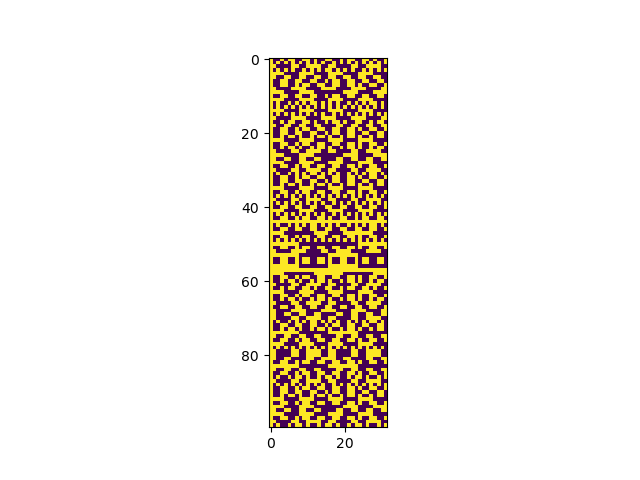

In [204]:
plt.imshow(data_matrix_1[0:100])

<IPython.core.display.Javascript object>


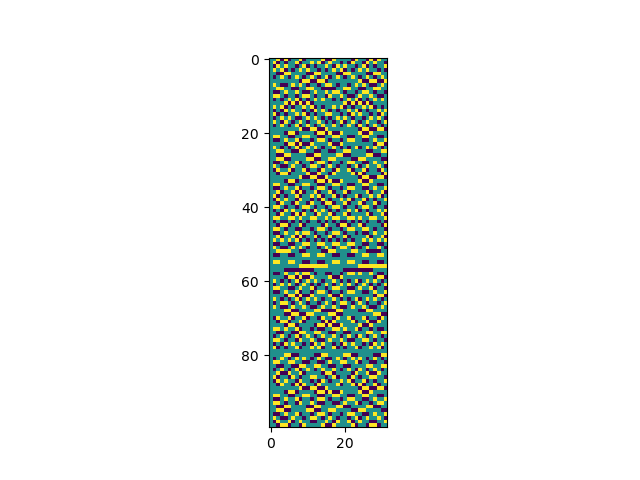

In [203]:
plt.imshow(data_matrix_2[0:100])

Looks like we can actually normalise the differences back to binary values...but won't make any difference to the covariance.